# **Example Road Network**

Roads are vital to the infrastructure of a community and, when blocked and/or (partially) destroyed 
cause numerous issues for various players. Therefore, it is imperative to assess the impact of loss in mobility when analyzing flood events and other hazards. 

FIAT offers a tool to compute the monetary impact of the road blockage/destruction based on the **extent of the hazard, the road type (e.g. motorway, trunk, primary roads), and the number of lanes.**

To run the FIAT model on a road network it is necessary to create the [exposure data](https://github.com/Deltares/Delft-FIAT/blob/master/docs/user_guide/data/exposure.qmd) and [vulnerability data](https://github.com/Deltares/Delft-FIAT/blob/master/docs/user_guide/data/vulnerability.qmd). So that when assessing a specific hazard event only the hazard map must be ingested to compute the impact.

To get the road network information FIAT downloads Open Street Map (OSM) data as default. Users can also ingest their own road network data.

However, we recommened OSM data as OSM offers detailed information about the road network such as the roadtype and the number of lanes, which are obligatory to calculate the flood impact. **This notebook will cover the road impact assessment based on OSM.**

>*Note: If the user wants to use their own data they musst assure to deliver the **number of lanes per segment***.

## Let's get started!

# **Step 1**: Import required packages

In [125]:
# First, all required packages must be installed.

from hydromt_fiat.fiat import FiatModel
from hydromt.log import setuplog
from pathlib import Path
import geopandas as gpd
import pandas as pd
import os 
import json
import yaml

# **Step 2:** Define the study area

FIAT requires the input of a region in form of a **shapely Polygon** to download the **OSM road dataset**. This can be done via **vector file** or **GeoJSON object** of the study area. We recommened to download the region from [Geojson.io](https://geojson.io/#map=2/0/20). 

**GeoJson.io**  
Draw a polygon on the map and create a polygon from the GeoJson Object. You can download a vector file, you need to refer to in the "region" tab in the *yaml* file using the file path. You can also copy the GeoJson code directly into the configuration file (see example in [configuration file](C:/Users/rautenba/hydromt_fiat/examples/data/road_network/configuration.yml)).

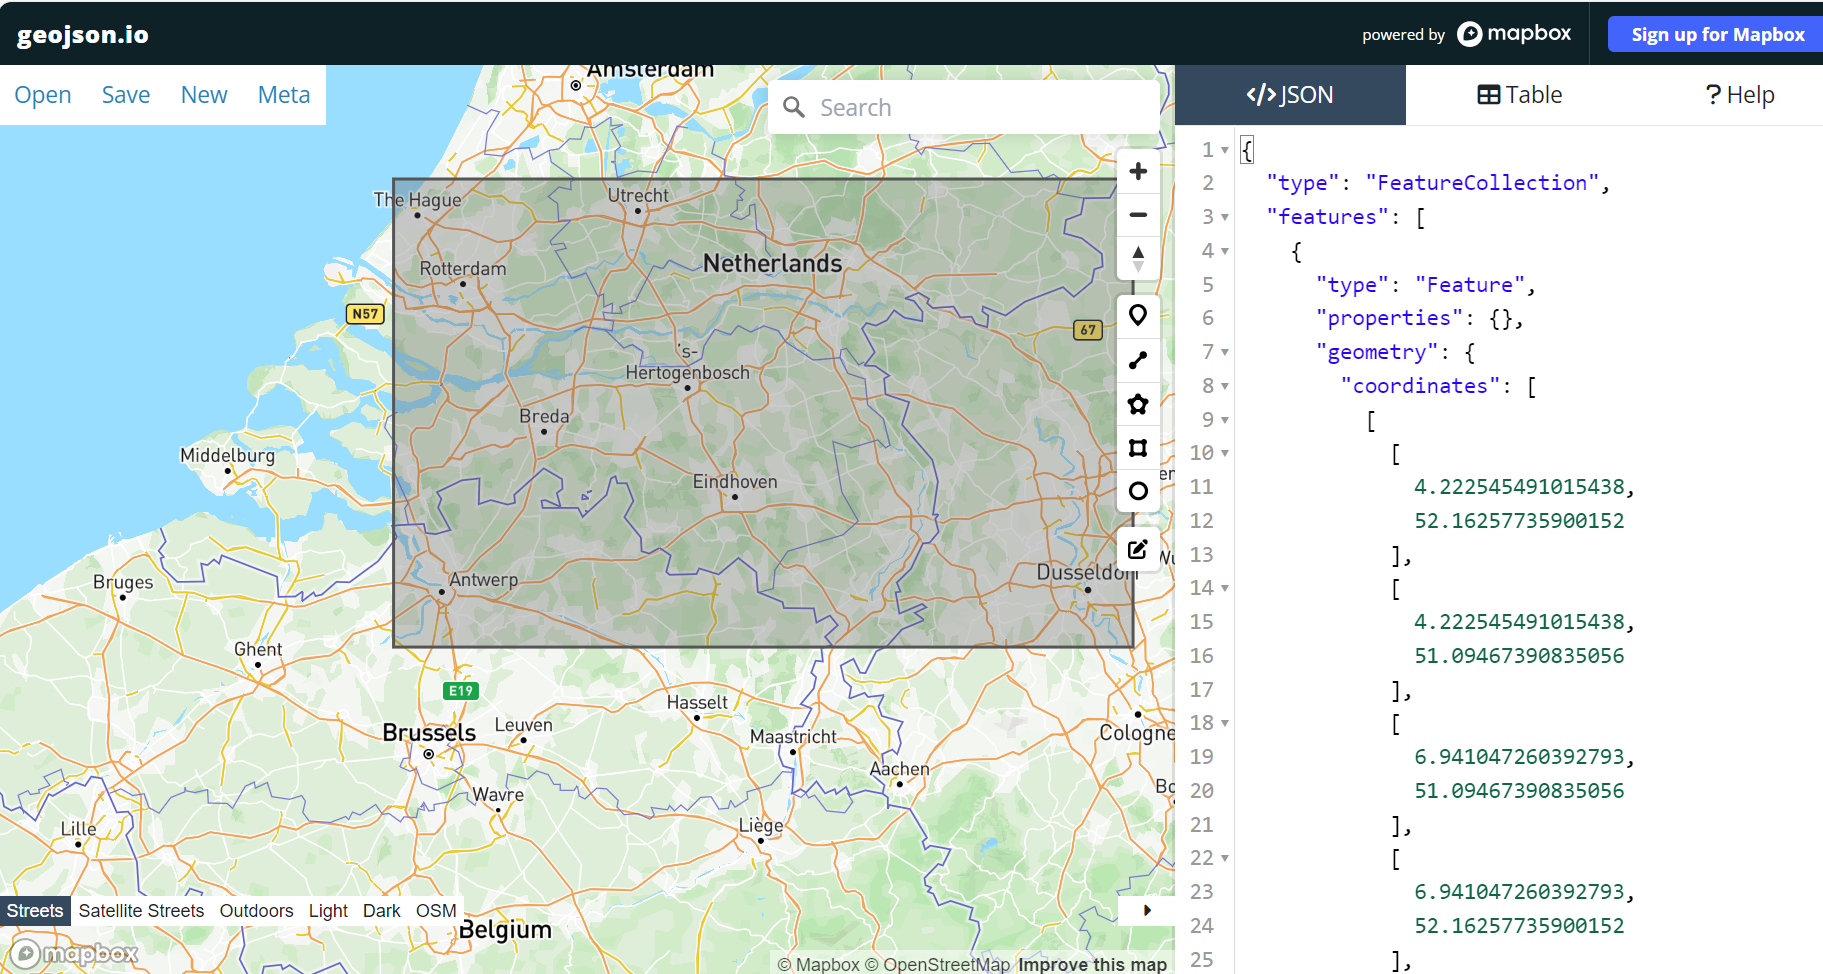

# **Step 3:** Create the configuration file

FIAT requires a configuration file in form of a *yaml*-file or a dictionary, in which the model parameters are defined. The configuration file must define the **vulnerability** and **exposure setup** and the **region**.
The required fields are:
  
*setup_road_vulnerability:*
- **vertical_unit**:Unit of vertical inundation (feet or meter)
- **threshold_value**: Threshold inundation height at which road is fully destroyed 
- **min_hazard_value**: minimum inundation height (recommended: 0)
- **max_hazard_value**: maximum inundation height (e.g. 6 meters) 
- **step_hazard_value**: discrete levels or steps of inundation height

*setup_exposure_roads:*
- **roads_fn**: File path to road network file or OSM data (for OSM data use: "OSM")
- **road_types**: Road type keys (if OSM data use keys from from OSM e.g. "motorway", "primary")
- **road_damage**: Damages per lane and per length unit
- **unit**: Unit of road length (feet or meter)

*region:*
- **region**: pre-defined region in form of a dictionary or shapely polygon

The provided parameters need to be incorporated into the YAML structure. Please check [here](C:/Users/rautenba/hydromt_fiat/examples/data/road_network/configuration.yml) for the setup of the *configuration.yml*. 

## **Step 3.1:** Load the configuration file

The *configuration.yml* should be placed in the "example"/ "data" / "road_network"  - folder.  
The file can be read in python and its information are converted into a python dictionary. </p>
<p><em>Note: Instead of loading a yaml file it is possible to create a python dictionary directly, built upon the structure seen below.</em></p>

In [129]:
# Let's read the configuration file holding the required information for the FIAT model 

with open(Path(os.path.abspath("")) / "data" / "road_network" / "configuration.yml", 'r') as file:
    config = yaml.safe_load(file)

print(json.dumps(config, indent=4, sort_keys=False))

{
    "cases": {
        "roads_from_OSM": {
            "data_catalogue": "C:/Users/rautenba/hydromt_fiat/examples/data/road_network/hydromt_fiat_catalog_USA.yml",
            "dir": "test_roads_from_OSM"
        },
        "road_network": {
            "new_root": "./data/road_network/output/road_network_example",
            "configuration": {
                "setup_road_vulnerability": {
                    "vertical_unit": "feet",
                    "threshold_value": 0.6,
                    "min_hazard_value": 0,
                    "max_hazard_value": 10,
                    "step_hazard_value": 1
                },
                "setup_exposure_roads": {
                    "roads_fn": "OSM",
                    "road_types": [
                        "motorway",
                        "primary",
                        "secondary",
                        "tertiary"
                    ],
                    "road_damage": "default_road_max_potential_damages",
           

# **Step 4**: <strong>Define variables for the FIAT model</strong>

To build the model some settings must be ingested as variables. So you need to set up the root path to the FIAT model, the logger settings, the region and the data catalog:
- `root`: Directory path from where the neccessary data for the FIAT model is stored. 
- `logger`: The logger variable defines the frequencies of log-entries during the initialisation of the model.
- `region`: Define the region as a variable from the config dictionary.
- `data_catalog_yml`: Define the data catalogue as a variable from the config dictionary.



In [130]:
# Set up Fiat Model
root = Path(os.path.abspath(""))  / "data" / "road_network"

# Set up the logger
logger = setuplog("hydromt_fiat", log_level=10)

# Set up region
region = config["cases"]["region"]

# Set up datacatalog
data_catalog_yml = str(config["cases"]["roads_from_OSM"]["data_catalogue"])

2023-10-23 18:57:22,714 - hydromt_fiat - log - INFO - HydroMT version: 0.8.0


INFO:hydromt_fiat:HydroMT version: 0.8.0


# **Step 4:** Run the FIAT model

It's time to run the road network FIAT model. The output will be stored in the root-directory. 

The output will be an **exposure folder** incl. *exposure.csv* together with vector data files, a **hazard folder** (empty) and a **vulnerability folder** incl. *damage_curve.csv*. 

In [134]:
fm = FiatModel(root=root, mode="w+", data_libs=[data_catalog_yml], logger=logger)
region = gpd.GeoDataFrame.from_features(config["cases"]["region"], crs=4326)
fm.build(region={"geom": region}, opt=config["cases"]["road_network"]["configuration"])
fm.write()

2023-10-23 19:06:31,994 - hydromt_fiat - data_catalog - INFO - Parsing data catalog from C:/Users/rautenba/hydromt_fiat/examples/data/road_network/hydromt_fiat_catalog_USA.yml


INFO:hydromt_fiat:Parsing data catalog from C:/Users/rautenba/hydromt_fiat/examples/data/road_network/hydromt_fiat_catalog_USA.yml
  warnings.warn(



2023-10-23 19:06:32,007 - hydromt_fiat - model_api - INFO - Initializing fiat model from hydromt_fiat (v0.2.1.dev0).


INFO:hydromt_fiat:Initializing fiat model from hydromt_fiat (v0.2.1.dev0).


2023-10-23 19:06:32,017 - hydromt_fiat - model_api - INFO - setup_region.region: {'geom':                                             geometry
0  POLYGON ((-79.92170 32.76821, -79.92170 32.777...}


INFO:hydromt_fiat:setup_region.region: {'geom':                                             geometry
0  POLYGON ((-79.92170 32.76821, -79.92170 32.777...}


2023-10-23 19:06:32,020 - hydromt_fiat - basin_mask - DEBUG - Parsed region (kind=geom): {'geom': 'GeoDataFrame [-79.94881763  32.7682089  -79.92169687  32.77745096] (crs = EPSG:4326)'}


DEBUG:hydromt_fiat:Parsed region (kind=geom): {'geom': 'GeoDataFrame [-79.94881763  32.7682089  -79.92169687  32.77745096] (crs = EPSG:4326)'}


2023-10-23 19:06:32,023 - hydromt_fiat - model_api - INFO - setup_road_vulnerability.vertical_unit: feet


INFO:hydromt_fiat:setup_road_vulnerability.vertical_unit: feet


2023-10-23 19:06:32,025 - hydromt_fiat - model_api - INFO - setup_road_vulnerability.threshold_value: 0.6


INFO:hydromt_fiat:setup_road_vulnerability.threshold_value: 0.6


2023-10-23 19:06:32,027 - hydromt_fiat - model_api - INFO - setup_road_vulnerability.min_hazard_value: 0


INFO:hydromt_fiat:setup_road_vulnerability.min_hazard_value: 0


2023-10-23 19:06:32,028 - hydromt_fiat - model_api - INFO - setup_road_vulnerability.max_hazard_value: 10


INFO:hydromt_fiat:setup_road_vulnerability.max_hazard_value: 10


2023-10-23 19:06:32,030 - hydromt_fiat - model_api - INFO - setup_road_vulnerability.step_hazard_value: 1


INFO:hydromt_fiat:setup_road_vulnerability.step_hazard_value: 1


2023-10-23 19:06:32,032 - hydromt_fiat - model_api - INFO - setup_exposure_roads.roads_fn: OSM


INFO:hydromt_fiat:setup_exposure_roads.roads_fn: OSM


2023-10-23 19:06:32,034 - hydromt_fiat - model_api - INFO - setup_exposure_roads.road_damage: default_road_max_potential_damages


INFO:hydromt_fiat:setup_exposure_roads.road_damage: default_road_max_potential_damages


2023-10-23 19:06:32,035 - hydromt_fiat - model_api - INFO - setup_exposure_roads.road_types: ['motorway', 'primary', 'secondary', 'tertiary']


INFO:hydromt_fiat:setup_exposure_roads.road_types: ['motorway', 'primary', 'secondary', 'tertiary']


2023-10-23 19:06:32,036 - hydromt_fiat - model_api - INFO - setup_exposure_roads.unit: meter


INFO:hydromt_fiat:setup_exposure_roads.unit: meter


2023-10-23 19:06:32,041 - hydromt_fiat - exposure_vector - INFO - Setting up roads...


INFO:hydromt_fiat:Setting up roads...


2023-10-23 19:06:32,165 - hydromt_fiat - exposure_vector - INFO - The damage function 'roads' is selected for all of the structure damage to the roads.


INFO:hydromt_fiat:The damage function 'roads' is selected for all of the structure damage to the roads.


2023-10-23 19:06:32,167 - hydromt_fiat - data_catalog - INFO - DataCatalog: Getting default_road_max_potential_damages DataFrame csv data from C:\Users\rautenba\hydromt_fiat\examples\data\road_network\us_road_damage.csv


INFO:hydromt_fiat:DataCatalog: Getting default_road_max_potential_damages DataFrame csv data from C:\Users\rautenba\hydromt_fiat\examples\data\road_network\us_road_damage.csv


2023-10-23 19:06:32,170 - hydromt_fiat - dataframe - INFO - DataFrame: Read csv data.


INFO:hydromt_fiat:DataFrame: Read csv data.


2023-10-23 19:06:32,185 - hydromt_fiat - exposure_vector - INFO - Setting exposure geometries...


INFO:hydromt_fiat:Setting exposure geometries...


2023-10-23 19:06:32,186 - hydromt_fiat - exposure_vector - INFO - Setting geometry name to roads...


INFO:hydromt_fiat:Setting geometry name to roads...


2023-10-23 19:06:32,190 - hydromt_fiat - fiat - INFO - Updating all data objects...


INFO:hydromt_fiat:Updating all data objects...


2023-10-23 19:06:32,195 - hydromt_fiat - model_api - ERROR - Default config file not found at c:\Users\rautenba\hydromt_fiat\examples\data\fiat\settings.toml


ERROR:hydromt_fiat:Default config file not found at c:\Users\rautenba\hydromt_fiat\examples\data\fiat\settings.toml


2023-10-23 19:06:32,198 - hydromt_fiat - model_api - WARNING - Replacing geom: region


2023-10-23 19:06:32,200 - hydromt_fiat - fiat - INFO - Writing model data to c:\Users\rautenba\hydromt_fiat\examples\data\road_network


INFO:hydromt_fiat:Writing model data to c:\Users\rautenba\hydromt_fiat\examples\data\road_network


2023-10-23 19:06:32,202 - hydromt_fiat - model_api - INFO - Writing model config to c:\Users\rautenba\hydromt_fiat\examples\data\road_network\settings.toml


INFO:hydromt_fiat:Writing model config to c:\Users\rautenba\hydromt_fiat\examples\data\road_network\settings.toml


2023-10-23 19:06:32,206 - hydromt_fiat - model_api - DEBUG - Writing file exposure/region.gpkg


DEBUG:hydromt_fiat:Writing file exposure/region.gpkg


2023-10-23 19:06:32,270 - hydromt_fiat - model_api - DEBUG - Writing file exposure/roads.gpkg


DEBUG:hydromt_fiat:Writing file exposure/roads.gpkg


2023-10-23 19:06:32,328 - hydromt_fiat - fiat - INFO - Writing model exposure table file to exposure/exposure.csv.


INFO:hydromt_fiat:Writing model exposure table file to exposure/exposure.csv.


2023-10-23 19:06:32,333 - hydromt_fiat - fiat - INFO - Writing model vulnerability_curves table file to vulnerability/vulnerability_curves.csv.


INFO:hydromt_fiat:Writing model vulnerability_curves table file to vulnerability/vulnerability_curves.csv.


2023-10-23 19:06:32,336 - hydromt_fiat - fiat - INFO - Updating all data objects...


INFO:hydromt_fiat:Updating all data objects...


2023-10-23 19:06:32,338 - hydromt_fiat - model_api - WARNING - Replacing geom: roads


2023-10-23 19:06:32,341 - hydromt_fiat - model_api - WARNING - Replacing geom: region


2023-10-23 19:06:32,344 - hydromt_fiat - fiat - INFO - Writing model data to c:\Users\rautenba\hydromt_fiat\examples\data\road_network


INFO:hydromt_fiat:Writing model data to c:\Users\rautenba\hydromt_fiat\examples\data\road_network


2023-10-23 19:06:32,347 - hydromt_fiat - model_api - INFO - Writing model config to c:\Users\rautenba\hydromt_fiat\examples\data\road_network\settings.toml


INFO:hydromt_fiat:Writing model config to c:\Users\rautenba\hydromt_fiat\examples\data\road_network\settings.toml


2023-10-23 19:06:32,350 - hydromt_fiat - model_api - DEBUG - Writing file exposure/region.gpkg


DEBUG:hydromt_fiat:Writing file exposure/region.gpkg


2023-10-23 19:06:32,470 - hydromt_fiat - model_api - DEBUG - Writing file exposure/roads.gpkg


DEBUG:hydromt_fiat:Writing file exposure/roads.gpkg


2023-10-23 19:06:32,589 - hydromt_fiat - fiat - INFO - Writing model exposure table file to exposure/exposure.csv.


INFO:hydromt_fiat:Writing model exposure table file to exposure/exposure.csv.


2023-10-23 19:06:32,596 - hydromt_fiat - fiat - INFO - Writing model vulnerability_curves table file to vulnerability/vulnerability_curves.csv.


INFO:hydromt_fiat:Writing model vulnerability_curves table file to vulnerability/vulnerability_curves.csv.


# **Done!**
Your **FIAT model** created the exposure and vulnerability files for the road network. Using that data in combination with a hazard map, the impact for the defined hazard can be computed. 

Let's have a look at the output!

In [133]:
#Load exposure.csv into dataframe
df_exposure = pd.read_csv(Path(os.path.abspath("")) / "data" / "road_network"  /  "exposure" / "exposure.csv")

#Load exposure geopackage into GeoDataFrame
gdf_exposure =gpd.read_file(Path(os.path.abspath("")) / "data" / "road_network"  /  "exposure" /  "roads.gpkg")

#Merge dataframe with GeoDataFrame
merged_gdf = gdf_exposure.merge(df_exposure, left_on='Object ID', right_on='Object ID', how='inner')

#Display the road network
road_network = merged_gdf.explore(column = 'Max Potential Damage: Structure')
road_network

In [135]:
#Load vulnerability.csv into dataframe
df_vulnerability = pd.read_csv(Path(os.path.abspath("")) / "data" / "road_network"  /  "vulnerability" / "vulnerability_curves.csv")
df_vulnerability

,#UNIT=feet
#METHOD,mean
water depth [feet],roads
0.0,0.0
0.59,0.0
0.6,1.0
1.0,1.0
2.0,1.0
3.0,1.0
4.0,1.0
5.0,1.0
